# "Overhyped" vs. "Underrated"

Meu foco neste projeto é apresentar uma identificação de "Overhyped" vs. "Underrated". Deste modo, pretendo explorar como identificar livros que podem estar superestimados (overhyped) ou subestimados (underrated) usando um dos [datasets do Goodreads](https://mengtingwan.github.io/data/goodreads.html). É importante ressaltar que **não** é um critério absoluto nem decisivo para classificar um livro, mas foi uma análise que gostei de fazer, principalmente pois foi uma análise inspirada por uma amiga, que leu um *best-seller* em um clube do livro e a opinião foi unânime: **ninguém gostou da leitura**.

Como o conjunto de dados completo é extremamente grande, decidi utilizar o subconjunto de dados de livros do gênero *Mystery, Thriller & Crime*. Fiz o download dos dados utilizando as instruções deste [notebook](https://github.com/MengtingWan/goodreads/blob/master/download.ipynb):

In [1]:
import pandas as pd
import requests
import os
import warnings
import re
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

In [2]:
# Nomes dos datasets do Goodreads:
file_names = pd.read_csv(os.path.join('dados', 'dataset_names.csv'))
file_names

,type,name
0,complete,goodreads_book_works.json.gz
1,complete,goodreads_book_authors.json.gz
2,complete,goodreads_book_series.json.gz
3,complete,goodreads_books.json.gz
4,complete,goodreads_book_genres_initial.json.gz
5,byGenre,goodreads_books_children.json.gz
6,byGenre,goodreads_books_comics_graphic.json.gz
7,byGenre,goodreads_books_fantasy_paranormal.json.gz
8,byGenre,goodreads_books_history_biography.json.gz
9,byGenre,goodreads_books_mystery_thriller_crime.json.gz


In [3]:
# Fazendo o download dos dados de livros de Mistério, Crime e Thriller.

dataset_name = 'goodreads_books_mystery_thriller_crime.json.gz'

url = 'https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/goodreads/byGenre/'+dataset_name

filepath = os.path.join('dados/', 'goodreads_books_mystery_thriller_crime.json.gz')

with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(filepath, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
print('Dataset', dataset_name, 'foi baixado com sucesso!')


Dataset goodreads_books_mystery_thriller_crime.json.gz foi baixado com sucesso!


In [4]:
# Lendo os dados:
df = pd.read_json(filepath, compression='gzip', lines=True)

# Verificando os nomes das colunas
print(df.columns)

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')


Nem todas as colunas são úteis, então selecionei apenas as colunas relevantes para a nossa análise.

In [5]:
# Selecionando colunas relevantes
colunas_relevantes = ['title', 'title_without_series', 'authors', 'average_rating', 'ratings_count', 'language_code']
df = df[colunas_relevantes]

# Verificando as primeiras linhas
df.head()

,title,title_without_series,authors,average_rating,ratings_count,language_code
0,"Crowner Royal (Crowner John Mystery, #13)","Crowner Royal (Crowner John Mystery, #13)","[{'author_id': '37778', 'role': ''}]",3.93,186,
1,The House of Memory (Pluto's Snitch #2),The House of Memory (Pluto's Snitch #2),"[{'author_id': '242185', 'role': ''}]",4.33,269,eng
2,The Slaughtered Virgin of Zenopolis (Inspector Capstan #1),The Slaughtered Virgin of Zenopolis (Inspector Capstan #1),"[{'author_id': '15104629', 'role': ''}, {'author_id': '14425713', 'role': ''}]",3.49,192,eng
3,"Dead in the Morning (Patrick Grant, #1)","Dead in the Morning (Patrick Grant, #1)","[{'author_id': '190988', 'role': ''}]",3.30,52,
4,Aristotele e i misteri di Eleusi,Aristotele e i misteri di Eleusi,"[{'author_id': '337108', 'role': ''}, {'author_id': '4585413', 'role': 'Translator'}, {'author_id': '1093599', 'role': 'Notes'}]",3.54,22,ita


O livro que inspirou essa análise é o "Summit Lake", então vou verificar se ele consta no nosso database:


In [6]:
df[df['title'] == 'Summit Lake']

,title,title_without_series,authors,average_rating,ratings_count,language_code
20877,Summit Lake,Summit Lake,"[{'author_id': '13922088', 'role': ''}]",3.95,242,
49723,Summit Lake,Summit Lake,"[{'author_id': '13922088', 'role': ''}]",3.95,6,
58843,Summit Lake,Summit Lake,"[{'author_id': '13922088', 'role': ''}]",3.95,283,
62333,Summit Lake,Summit Lake,"[{'author_id': '13922088', 'role': ''}]",3.95,18,
72532,Summit Lake,Summit Lake,"[{'author_id': '13922088', 'role': ''}]",3.95,11,
94428,Summit Lake,Summit Lake,"[{'author_id': '13922088', 'role': ''}]",3.95,1502,eng


Desse modo, percebi que há repetição de alguns títulos, então vou normalizar os títulos para recalcular a média, além de remover valores ausentes das colunas *average_rating* e *ratings_count*.

In [7]:
# Limpeza de valores ausentes
df = df.dropna(subset=['average_rating', 'ratings_count'])

# Função que normaliza títulos dos livros:
def normalizar_titulo(titulo):

    # Convertendo para minúsculas
    titulo = titulo.lower()
    
    # Removendo pontuação e caracteres especiais
    titulo = re.sub(r'[^\w\s]', '', titulo)
    
    # Removendo espaços extras
    titulo = re.sub(r'\s+', ' ', titulo).strip()
    
    # Removendo informações de série (ex.: "#3", "Sophie Green Mystery")
    titulo = re.sub(r'\b(?:#\d+|series|mystery|thriller|crime)\b', '', titulo)
    
    # Removendo espaços extras novamente
    titulo = re.sub(r'\s+', ' ', titulo).strip()
    
    return titulo

# Função para verificar se o título contém pelo menos uma letra
def contem_letras(titulo):
    # Verificando se há pelo menos uma letra do alfabeto (maiúscula ou minúscula)
    return bool(re.search(r'[a-zA-Z]', str(titulo)))

# Aplicando a normalização de títulos ao dataframe:
df['title_normalized'] = df['title'].apply(normalizar_titulo)

df = df[df['title_normalized'].apply(contem_letras)]

# Agrupando por título normalizado e recalculando a média 
df_agrupado = df.groupby('title_normalized', as_index=False, sort=False).apply(lambda x: pd.Series({
    'authors': x['authors'].iloc[0],
    'ratings_count': x['ratings_count'].sum(),
    'average_rating': (x['average_rating'] * x['ratings_count']).sum() / x['ratings_count'].sum(),
    'language_code':  x[x['language_code'] != '']['language_code'].iloc[0] if any(x['language_code'] != '') else '',
    'title': x['title'].iloc[0]
})).reset_index(drop=True)

# Filtrando avaliações insignificantes e outras colunas:
df_agrupado = df_agrupado[df_agrupado['ratings_count'] > 20]
df_agrupado = df_agrupado[df_agrupado['title_normalized'] != ""]
df_agrupado = df_agrupado[df_agrupado['language_code'].str.contains('en-US|en-GB|eng', case=False, na=False)]
df_agrupado.drop(['title_normalized', 'language_code'], axis = 1, inplace=True)

df_agrupado.head()


,authors,ratings_count,average_rating,title
0,"[{'author_id': '37778', 'role': ''}]",189,3.93,"Crowner Royal (Crowner John Mystery, #13)"
1,"[{'author_id': '242185', 'role': ''}]",269,4.33,The House of Memory (Pluto's Snitch #2)
2,"[{'author_id': '15104629', 'role': ''}, {'author_id': '14425713', 'role': ''}]",195,3.49,The Slaughtered Virgin of Zenopolis (Inspector Capstan #1)
3,"[{'author_id': '190988', 'role': ''}]",66,3.30,"Dead in the Morning (Patrick Grant, #1)"
5,"[{'author_id': '123715', 'role': ''}, {'author_id': '552417', 'role': 'Narrator'}]",1519,3.96,A Murder is Announced


Verificando se as repetições sumiram:

In [8]:
df_agrupado[df_agrupado['title'] == 'Summit Lake']

,authors,ratings_count,average_rating,title
18329,"[{'author_id': '13922088', 'role': ''}]",2062,3.95,Summit Lake


Pelo gráfico a seguir, livros com poucas avaliações apresentam uma grande variabilidade nas notas médias, variando de cerca de 1,5 a 5. No entanto, conforme o número de avaliações aumenta, as notas tendem a se concentrar entre 3,5 e 4,5. Isso ocorre pois um pequeno grupo de leitores pode influenciar significativamente a média quando há poucas avaliações, o que não ocorre para livros com um número mais alto de avaliações.

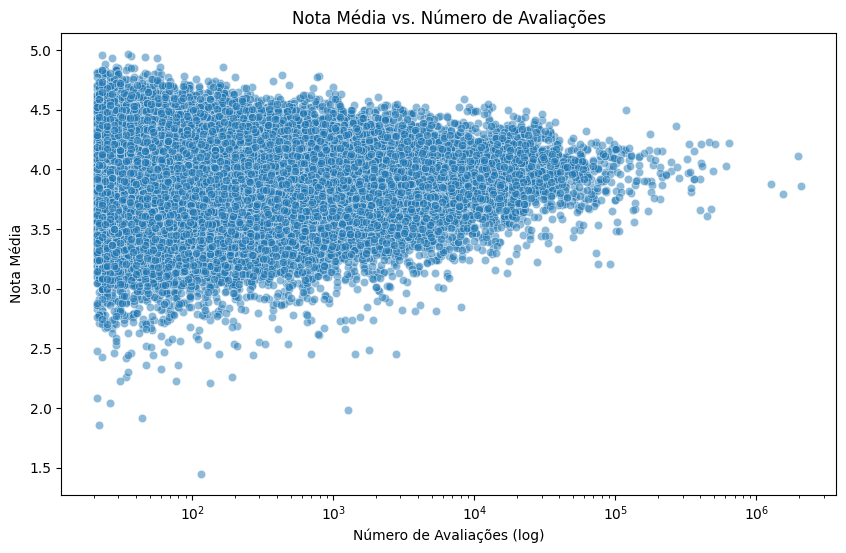

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_agrupado, x='ratings_count', y='average_rating', alpha=0.5)
plt.xscale('log')  # Usando escala log para ratings_count
plt.title('Nota Média vs. Número de Avaliações')
plt.xlabel('Número de Avaliações (log)')
plt.ylabel('Nota Média')
plt.show()

A seguir, calculei o score de livros superestimados e subestimados, considerando a popularidade e a nota. Ou seja, o overhyped_score indica livros muito populares, mas que não foram tão bem avaliados, e o underrated_score identifica livros bem avaliados que não são tão populares.

Desse modo, se um livro possui overhyped_score > 1, pode significar que sua popularidade está desproporcionalmente alta em relação à sua nota média, e, se um livro possui underrated_score > 1 pode significar que o livro possui muita qualidade (é muito bem avaliado por quem o leu), mas poupas pessoas o conhecem ou o avaliaram.

In [10]:
# Normalização por percentil
df_agrupado['rating_percentile'] = df_agrupado['average_rating'].rank(pct=True)
df_agrupado['popularity_percentile'] = df_agrupado['ratings_count'].rank(pct=True)

# Calcular score de underrated/overhyped
df_agrupado['underrated_score'] = (df_agrupado['rating_percentile'] * 2) - df_agrupado['popularity_percentile']
df_agrupado['overhyped_score'] = (df_agrupado['popularity_percentile'] * 2) - df_agrupado['rating_percentile']

df_agrupado.head()


,authors,ratings_count,average_rating,title,rating_percentile,popularity_percentile,underrated_score,overhyped_score
0,"[{'author_id': '37778', 'role': ''}]",189,3.93,"Crowner Royal (Crowner John Mystery, #13)",0.570325,0.482926,0.657724,0.395527
1,"[{'author_id': '242185', 'role': ''}]",269,4.33,The House of Memory (Pluto's Snitch #2),0.935460,0.561167,1.309754,0.186874
2,"[{'author_id': '15104629', 'role': ''}, {'author_id': '14425713', 'role': ''}]",195,3.49,The Slaughtered Virgin of Zenopolis (Inspector Capstan #1),0.109400,0.490610,-0.271809,0.871819
3,"[{'author_id': '190988', 'role': ''}]",66,3.30,"Dead in the Morning (Patrick Grant, #1)",0.041256,0.242892,-0.160380,0.444527
5,"[{'author_id': '123715', 'role': ''}, {'author_id': '552417', 'role': 'Narrator'}]",1519,3.96,A Murder is Announced,0.617246,0.835733,0.398758,1.054221


Para visualização, selecionei o top 15 livros mais superestimados:

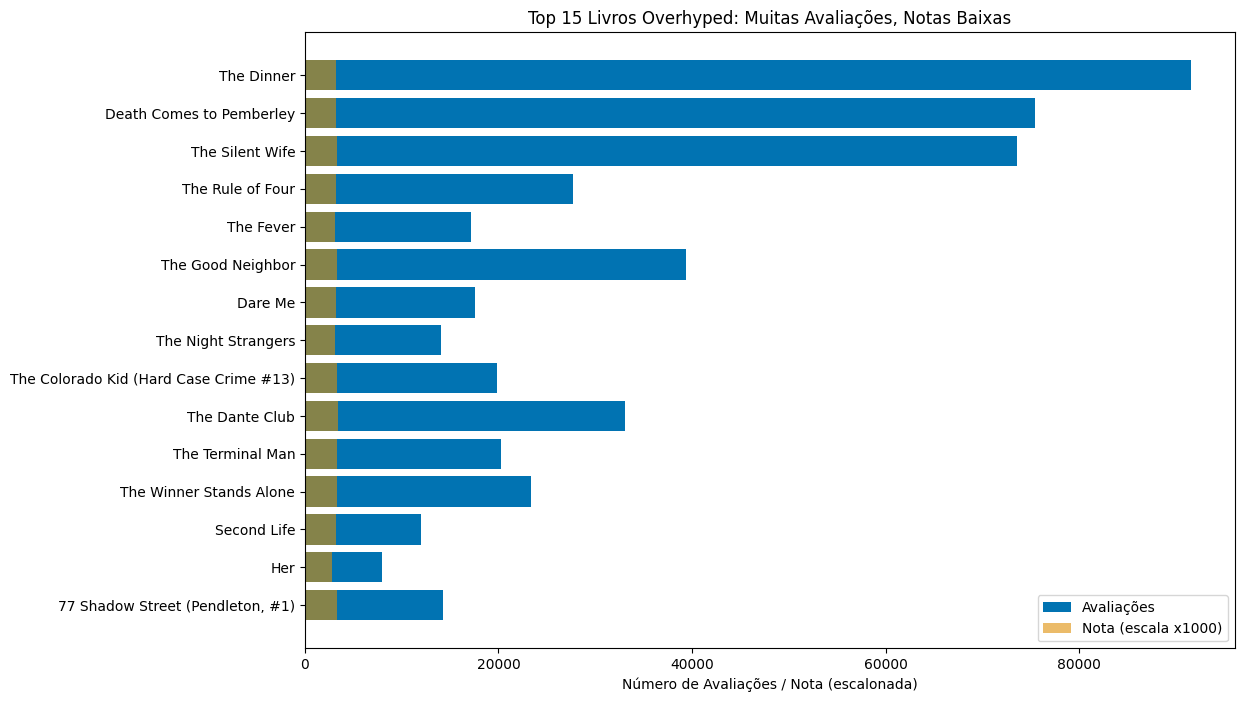

In [11]:
# Filtrando top 15 overhyped (maior score overhyped)
top_overhyped = df_agrupado.sort_values(by='overhyped_score', ascending=False).head(15)

colors = sns.color_palette("colorblind", 2)

plt.figure(figsize=(12, 8))
plt.barh(top_overhyped['title'], top_overhyped['ratings_count'], color=colors[0], label='Avaliações')
plt.barh(top_overhyped['title'], top_overhyped['average_rating'] * 1000, color=colors[1], alpha=0.6, label='Nota (escala x1000)')
plt.xlabel('Número de Avaliações / Nota (escalonada)')
plt.title('Top 15 Livros Overhyped: Muitas Avaliações, Notas Baixas')
plt.legend()
plt.gca().invert_yaxis()  # Inverter ordem para melhor visualização
plt.show()


e os top 15 livros mais subestimados:

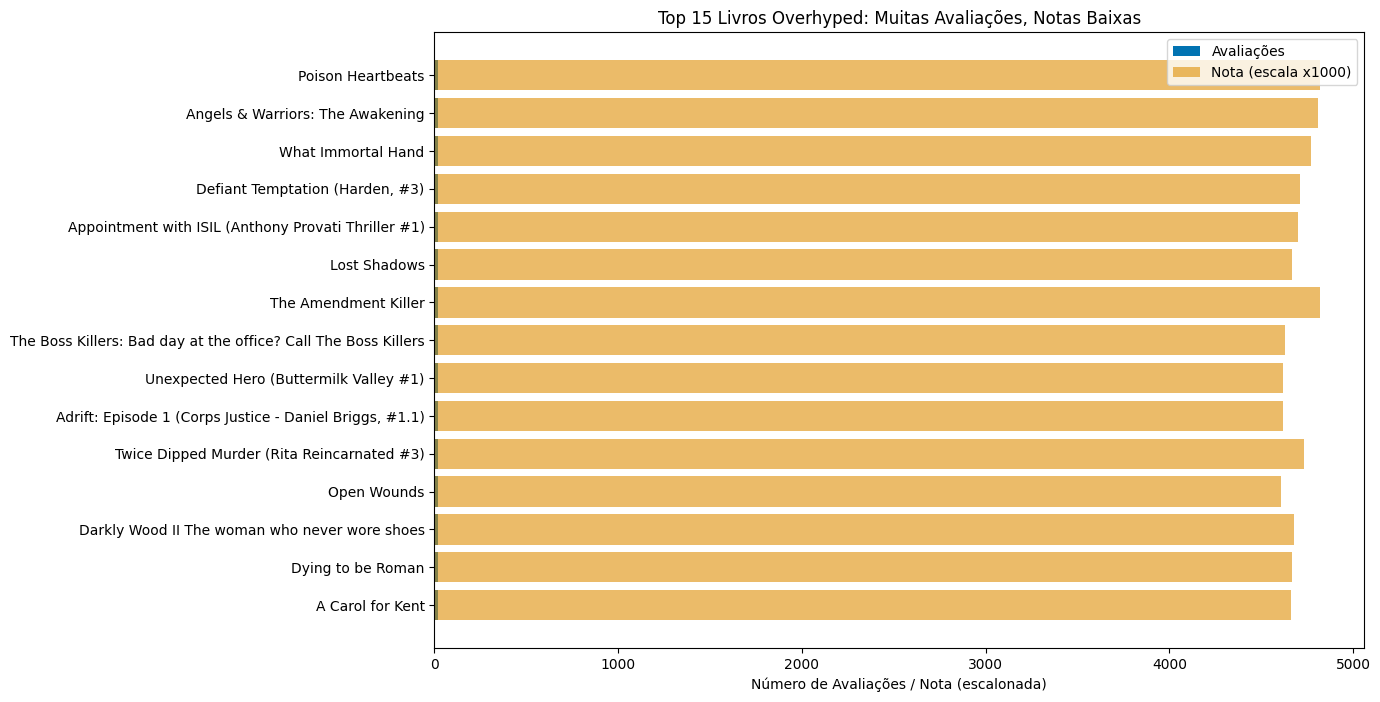

In [12]:
# Filtrando top 15 underrated (maior score underrated)
top_underrated = df_agrupado.sort_values(by='underrated_score', ascending=False).head(15)

plt.figure(figsize=(12, 8))
plt.barh(top_underrated['title'], top_underrated['ratings_count'], color=colors[0], label='Avaliações')
plt.barh(top_underrated['title'], top_underrated['average_rating'] * 1000, color=colors[1], alpha=0.6, label='Nota (escala x1000)')
plt.xlabel('Número de Avaliações / Nota (escalonada)')
plt.title('Top 15 Livros Overhyped: Muitas Avaliações, Notas Baixas')
plt.legend()
plt.gca().invert_yaxis()  # Inverter ordem para melhor visualização
plt.show()


Agora, a resposta para a pergunta que me motivou a essa análise: Será que Summit Lake pode ser considerado um livro superestimado?

A resposta é: poderíamos dizer que sim, se observamos o overhyped_score do livro, visto que está acima de 1 (e também levando em consideração a opinião unânime do clube do livro da minha amiga). Sabemos que se trata de um livro best-seller, então algumas das hipóteses são que pode ter gerado altas expectativas no público e ter decepcionado parte dele, além de ter sido muito impulsionado por marketing e tendências.

In [13]:
df_agrupado[df_agrupado['title'] == 'Summit Lake']


,authors,ratings_count,average_rating,title,rating_percentile,popularity_percentile,underrated_score,overhyped_score
18329,"[{'author_id': '13922088', 'role': ''}]",2062,3.95,Summit Lake,0.603211,0.86876,0.337662,1.134309
